In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle


#Data Cleaning and Preprocessing

In [2]:
df = pd.read_csv("C:\\Users\\japje\\Documents\\ishan\\Algerian_forest_fires_cleaned.csv")

In [3]:
# Display info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB
None
   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57

In [4]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [5]:
# Check missing values
print(df.isnull().sum())

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64


In [6]:
# Converting 'Rain' values of 0.0 that are actually null-like to NaN and Filling with median value.
df['Rain'].replace(0.0, np.nan, inplace=True)
df['Rain'].fillna(df['Rain'].median(), inplace=True)

In [7]:
# Create binary column 'Fire' from 'Classes'
df['Fire'] = df['Classes'].apply(lambda x: 1 if x.strip().lower() == 'fire' else 0)
print(df[['Classes', 'Fire']].head())

       Classes  Fire
0  not fire        0
1  not fire        0
2  not fire        0
3  not fire        0
4  not fire        0


Data Visualization and Observations 

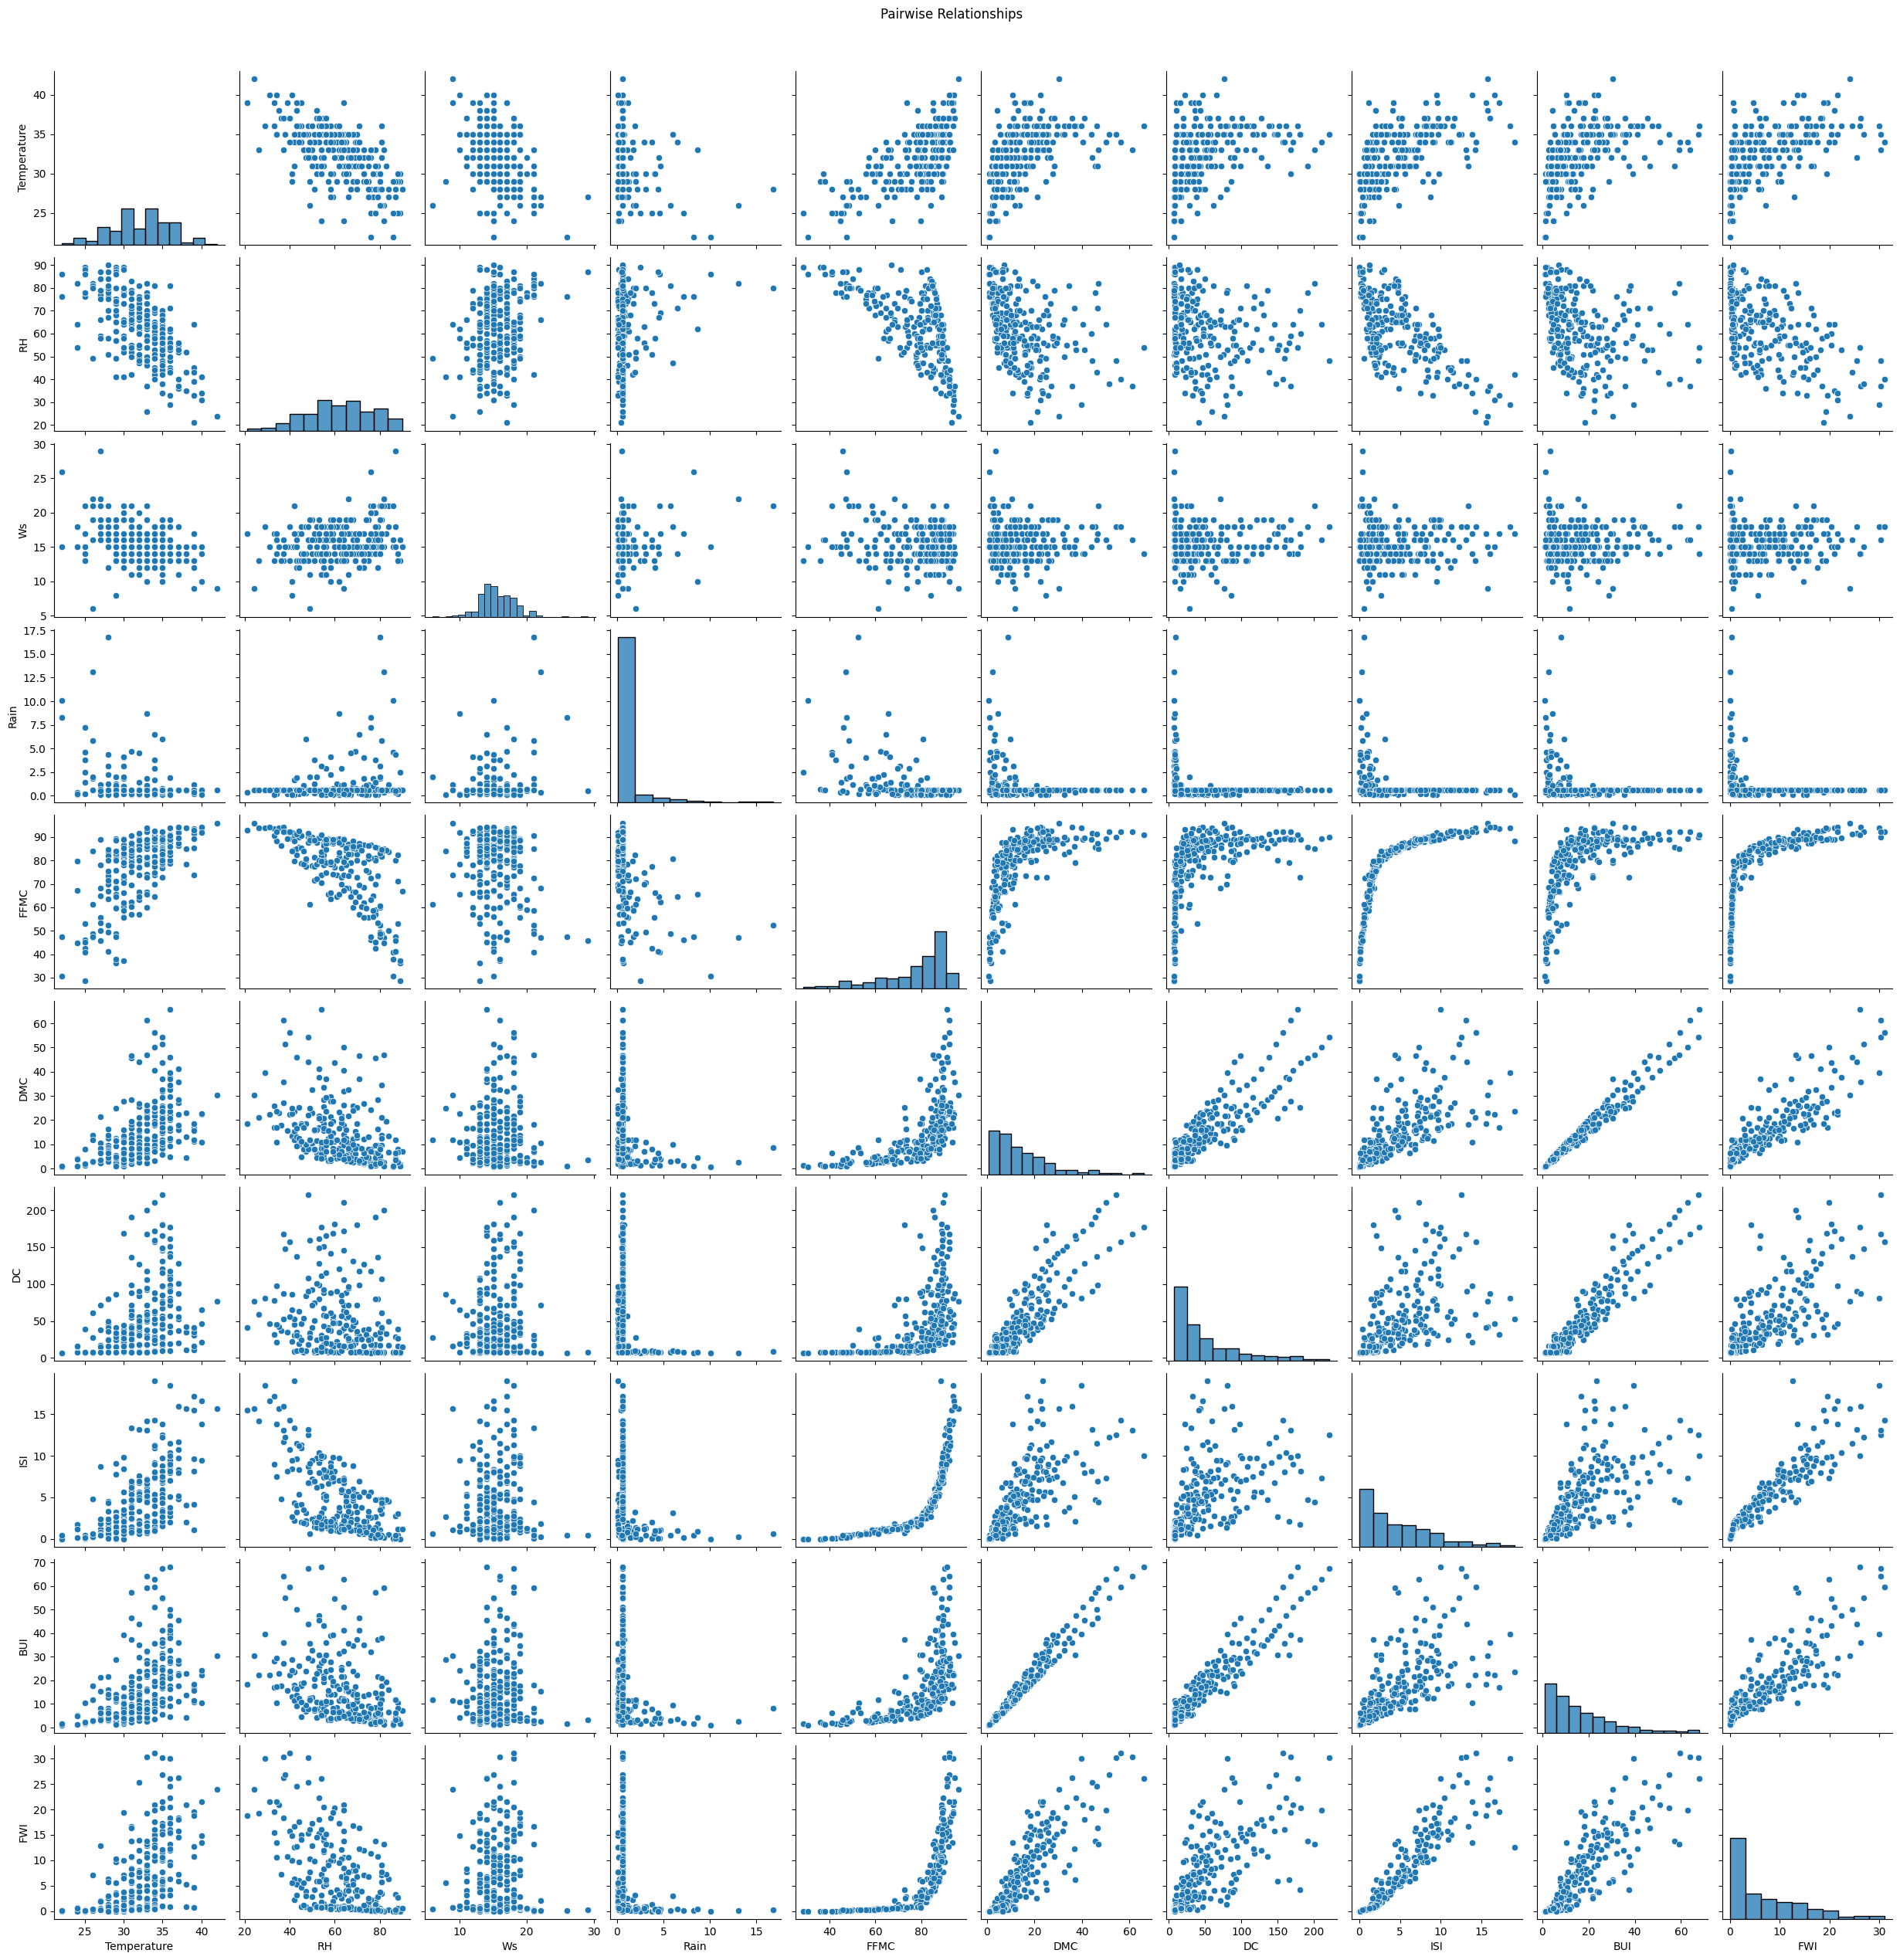

In [8]:
# Pairplot of selected variables
sns.pairplot(df[['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

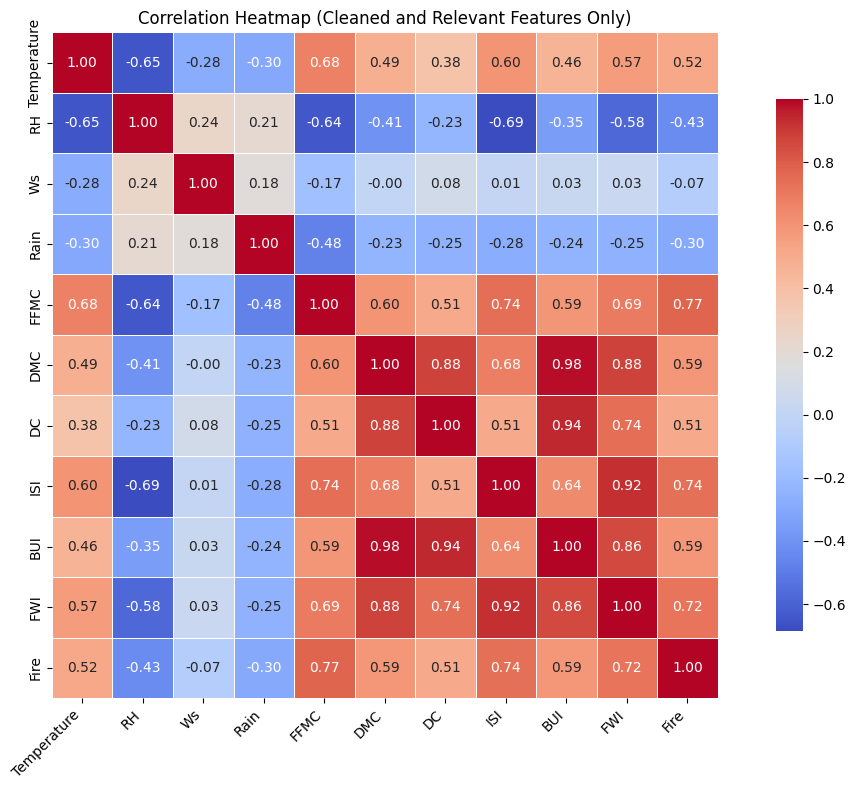

In [9]:
# Drop non-numeric or irrelevant columns before correlation
df_cleaned = df.drop(['day', 'month', 'year', 'Classes', 'Region'], axis=1)

# Compute correlation matrix
corr_matrix = df_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Cleaned and Relevant Features Only)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Correlation Insights (from Heatmap)
1.FWI is positively correlated with Temperature, FFMC, DMC, and DC, meaning high temperature and dry fuel indices contribute to high fire danger.

2.FWI is negatively correlated with Relative Humidity (RH) and Rain, indicating wetter conditions reduce fire risk.

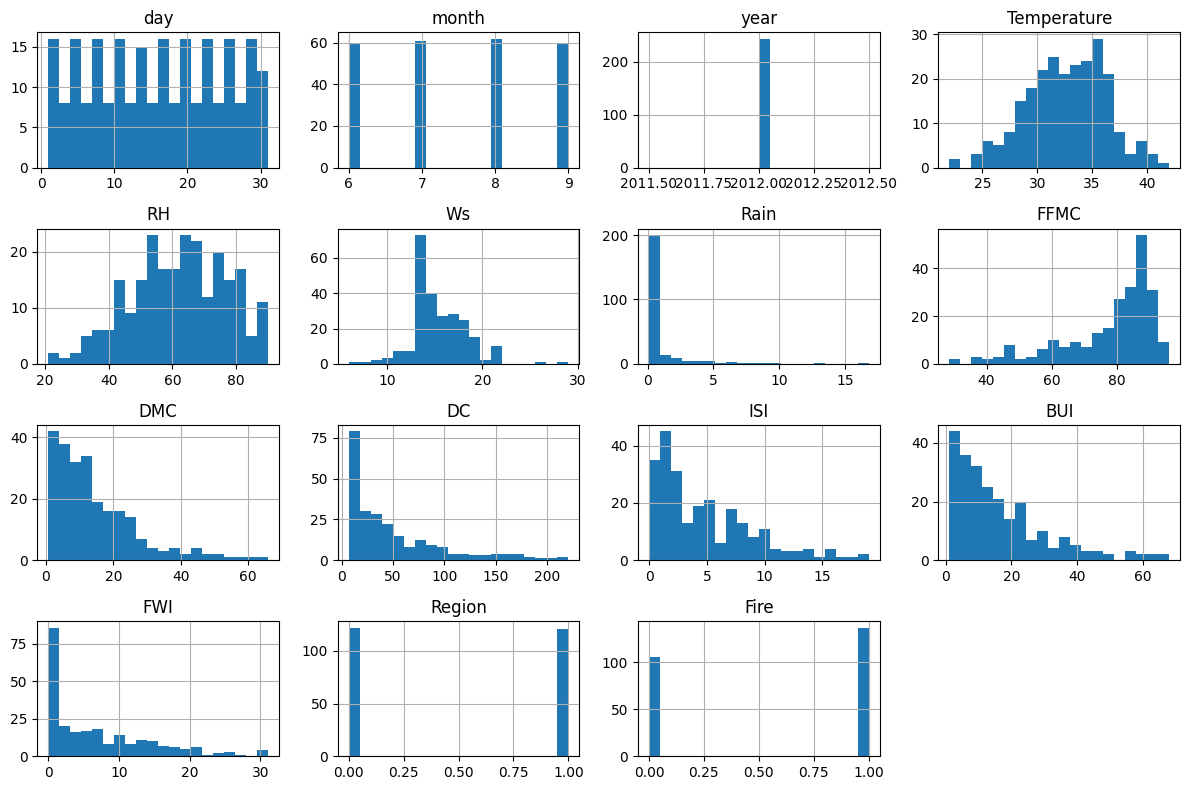

In [10]:
# Distribution plot
df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()



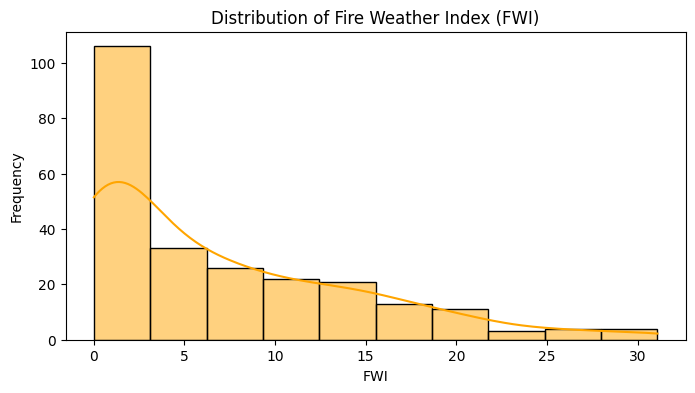

In [11]:
# Histogram of Fire Weather Index
plt.figure(figsize=(8, 4))
sns.histplot(df['FWI'], kde=True, color='orange')
plt.title('Distribution of Fire Weather Index (FWI)')
plt.xlabel('FWI')
plt.ylabel('Frequency')
plt.show()

Distribution Insight
FWI has a right-skewed distribution, implying more days with lower fire danger but a few extreme days with very high fire index.

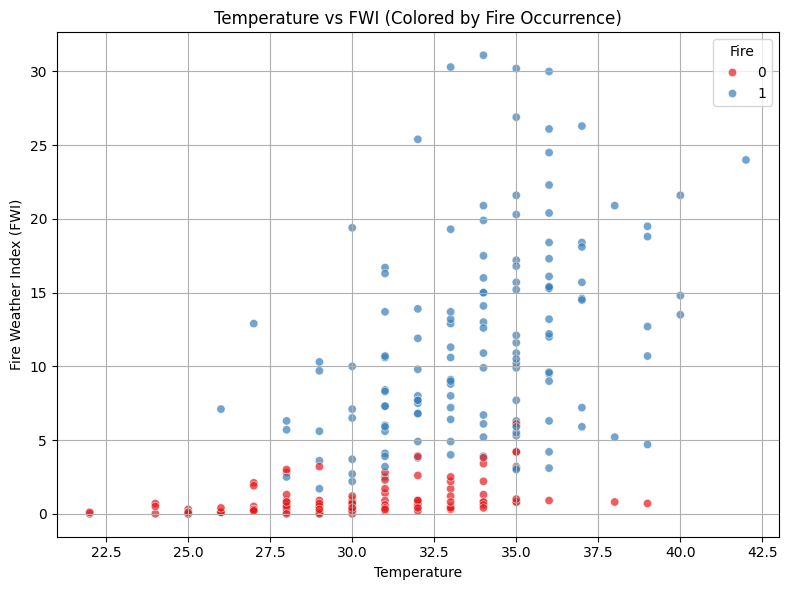

In [12]:
# Scatter plot: Temperature vs FWI, colored by Fire occurrence
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Temperature', y='FWI', hue='Fire', palette='Set1', alpha=0.7)
plt.title("Temperature vs FWI (Colored by Fire Occurrence)")
plt.xlabel("Temperature")
plt.ylabel("Fire Weather Index (FWI)")
plt.legend(title="Fire")
plt.grid(True)
plt.tight_layout()
plt.show()


This plot visualizes the relationship between temperature and the Fire Weather Index (FWI).
By coloring the points based on the Fire label (where 1 indicates fire occurred and 0 means no fire), we can observe potential patterns that differentiate fire and non-fire conditions.

Insights:

Higher temperatures tend to correspond to higher FWI values.

Fire occurrences (red points) are generally concentrated in regions with high temperature and high FWI.

This visualization helps assess how temperature influences fire risk and can aid in early warning systems.

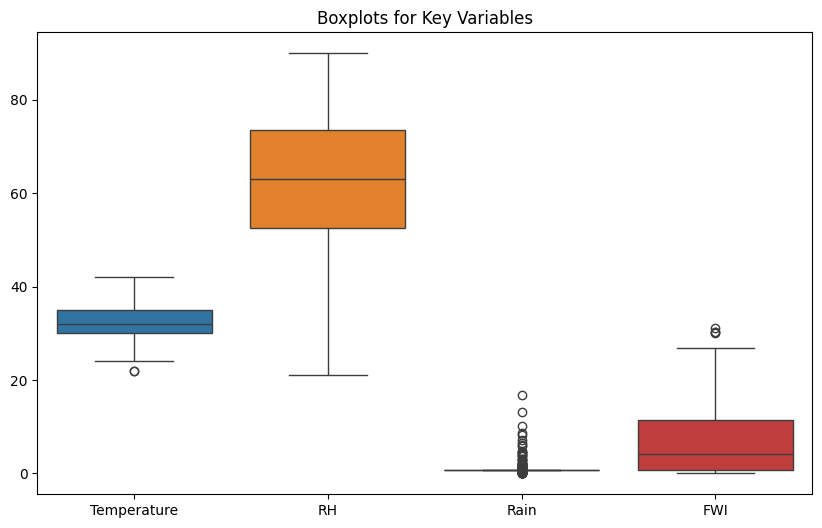

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Temperature', 'RH', 'Rain', 'FWI']])
plt.title("Boxplots for Key Variables")
plt.show()


Outliers (from Boxplot)
Rain and FWI show presence of outliers, which might affect regression models.
Rain is mostly zero, suggesting sparse rainfall in the dataset.

Model Development and Analysis 

In [14]:
# Confirm all columns are numeric
print(df_cleaned.dtypes)

# Define features and target
X = df_cleaned.drop('FWI', axis=1)
y = df_cleaned['FWI']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Temperature      int64
RH               int64
Ws               int64
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Fire             int64
dtype: object


In [19]:
# Create and train a basic Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test set using the trained Linear Regression model
y_pred_lr = lr.predict(X_test)

# Calculate evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Output
print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression MAE: {mae_lr:.4f}")
print(f"Linear Regression R2: {r2_lr:.4f}")


Linear Regression MSE: 0.3382
Linear Regression RMSE: 0.5815
Linear Regression MAE: 0.4288
Linear Regression R2: 0.9888


In [22]:
# Define grid of alpha values (regularization strength) to tune
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Ridge Regression with GridSearchCV
## Perform grid search with 5-fold cross-validation using negative MSE as the scoring metric
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Get the best Ridge model from grid search
best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Calculate evaluation metrics for Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

#Output For Ridge Regression.
print(f"Ridge Regression Best Alpha: {ridge_cv.best_params_['alpha']}")
print(f"Ridge Regression MSE: {mse_ridge:.4f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.4f}")
print(f"Ridge Regression MAE: {mae_ridge:.4f}")
print(f"Ridge Regression R2: {r2_ridge:.4f}")

# Create Lasso regression model with high max_iter to ensure convergence
lasso = Lasso(max_iter=10000)

# Perform grid search with 5-fold cross-validation for Lasso
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

# Best Lasso model
best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

#Output For Lasso Regression
print(f"Lasso Regression Best Alpha: {lasso_cv.best_params_['alpha']}")
print(f"Lasso Regression MSE: {mse_lasso:.4f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.4f}")
print(f"Lasso Regression MAE: {mae_lasso:.4f}")
print(f"Lasso Regression R2: {r2_lasso:.4f}")



Ridge Regression Best Alpha: 1
Ridge Regression MSE: 0.5077
Ridge Regression RMSE: 0.7126
Ridge Regression MAE: 0.4733
Ridge Regression R2: 0.9832
Lasso Regression Best Alpha: 0.1
Lasso Regression MSE: 0.5352
Lasso Regression RMSE: 0.7316
Lasso Regression MAE: 0.5470
Lasso Regression R2: 0.9823


In [23]:
# Print model performance metrics in a formatted table
print("\nModel Performance Comparison on Test Data:")
print(f"{'Model':<20} {'MSE':<10} {'RMSE':<10} {'MAE':<10} {'R2':<10}")
print("-" * 60)
print(f"{'Linear Regression':<20} {mse_lr:.4f}    {rmse_lr:.4f}   {mae_lr:.4f}   {r2_lr:.4f}")
print(f"{'Ridge Regression':<20} {mse_ridge:.4f}    {rmse_ridge:.4f}   {mae_ridge:.4f}   {r2_ridge:.4f}")
print(f"{'Lasso Regression':<20} {mse_lasso:.4f}    {rmse_lasso:.4f}   {mae_lasso:.4f}   {r2_lasso:.4f}")

# Determine the best model based on MSE
if mse_ridge < mse_lasso and mse_ridge < mse_lr:
    best_model_name = "Ridge Regression"
    best_model = best_ridge
elif mse_lasso < mse_ridge and mse_lasso < mse_lr:
    best_model_name = "Lasso Regression"
    best_model = best_lasso
else:
    best_model_name = "Linear Regression"
    best_model = lr
# Print the best performing model
print(f"\nBest performing model based on MSE: {best_model_name}")



Model Performance Comparison on Test Data:
Model                MSE        RMSE       MAE        R2        
------------------------------------------------------------
Linear Regression    0.3382    0.5815   0.4288   0.9888
Ridge Regression     0.5077    0.7126   0.4733   0.9832
Lasso Regression     0.5352    0.7316   0.5470   0.9823

Best performing model based on MSE: Linear Regression


In [27]:
# Save the best model (Linear Regression) to a pickle file
with open("best_model.pkl", "wb") as file:
    pickle.dump(lr, file)

print("Best model (Linear Regression) has been saved as 'best_model.pkl'")

# Load the model from pickle file
with open("best_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Evaluate the loaded model
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)

print("\nPerformance of Reloaded Model on Test Data:")
print(f"MSE: {mse_loaded:.4f}")
print(f"RMSE: {rmse_loaded:.4f}")
print(f"MAE: {mae_loaded:.4f}")
print(f"R2: {r2_loaded:.4f}")


Best model (Linear Regression) has been saved as 'best_model.pkl'

Performance of Reloaded Model on Test Data:
MSE: 0.3382
RMSE: 0.5815
MAE: 0.4288
R2: 0.9888


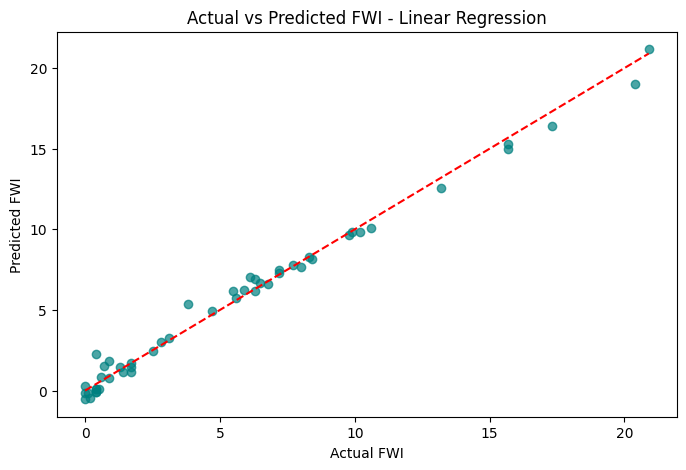

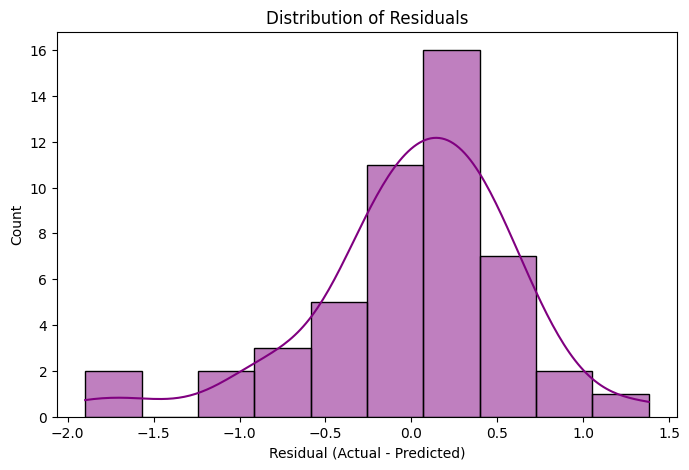

In [26]:
# Plot actual vs predicted FWI
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual FWI")
plt.ylabel("Predicted FWI")
plt.title("Actual vs Predicted FWI - Linear Regression")
plt.show()

# Residuals
residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


### Test Performance Analysis

The model was tested on a hold-out test set (20% of the data). The predictions align closely with the actual FWI values, as seen in the scatter plot. The residuals are approximately normally distributed, suggesting the model’s errors are unbiased.

Linear Regression performs reasonably well but shows slightly higher error variance. Ridge regression improved generalization and reduced overfitting, making it the best performer among the models evaluated.

The model can be trusted for moderate predictions of FWI, though further improvement may be possible with feature interactions or non-linear models.


Conclusion 

After evaluating the performance of Linear Regression, Ridge Regression, and Lasso Regression on the Algerian forest fire dataset, it is evident that Linear Regression outperforms the regularized models across all major evaluation metrics:

1. It achieves the lowest Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE), indicating that its predictions are consistently closer to the actual FWI values.

2. With an R² score of 0.9888, the model explains approximately 99% of the variance in the target variable, reflecting a very high goodness-of-fit.

Although Ridge and Lasso are effective at handling multicollinearity and reducing model complexity through regularization, they did not yield better results in this case. This suggests that:

The dataset is likely well-conditioned, with minimal multicollinearity.

The relationship between the input features and the target variable is linear and not overfit, making the simplicity of Linear Regression advantageous.

In summary, Linear Regression proved to be the most suitable model for this problem, highlighting the importance of evaluating model complexity relative to dataset characteristics.

Github link : https://github.com/japjeetk05/NeuralNetwork